In [1]:
import pandas as pd
from graph_traffic.merge_data import merge_data
from sklearn.model_selection import TimeSeriesSplit
from graph_traffic.get_data import get_mmagns
from graph_traffic.gradient_boosting import plot_feature_importances
from graph_traffic.custom_transformer import get_column_names, transform_df
from graph_traffic.model_selection import get_node_ids
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib as mpl
import xgboost as xgb
from sklearn.model_selection import cross_validate

mpl.rcParams['axes.grid'] = False


ids_to_use = get_node_ids()

data_dict = dict(
    ids_list=ids_to_use,  #[1001],#[3532, 3542, 3544, 3545, 3546, 3577, 3637, 3640, 3641, 4761, 4763],
    seq_len=4 * 24,
    with_graph=False,
    from_date="2019-01-01",
    to_date="2021-12-31",
    dataset_name="small",
    target="ocupacion",
    interactions="drop"
)

meteo_dict = {
    'rain': 'numerico_power',
    'wind': 'drop',
    'temperature': 'passthrough',
    'humidity': 'passthrough',
    'pressure': 'drop',
    'radiation': 'passthrough'
}
mmagns = get_mmagns(meteo_dict)

temporal_dict = {
    'year': 'passthrough',
    'season': 'ordinal',
    'month': 'passthrough',
    'day_of_month': 'passthrough',
    'weekday': 'drop',
    'hour': 'one_hot',
    'minute': 'drop',
    'bank_holiday': 'passthrough',
    'school_holiday': 'drop',
    'working_day': 'passthrough',
    'state_of_alarm': 'passthrough'
}

column_names = get_column_names(meteo_dict, temporal_dict, "drop", data_dict["target"])[1:]

scoring = ["neg_mean_absolute_error", "neg_mean_squared_error"]

C:\Users\Bened\PycharmProjects\madrid-traffic\env\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
ts_cv = TimeSeriesSplit(
    n_splits=3
)

In [12]:
best_params = dict()
train_data_sizes = dict()

train_x = dict()
train_y = dict()

test_x = dict()
test_y = dict()

for node_id in ids_to_use:
    df = merge_data(node_id, data_dict["from_date"], data_dict["to_date"], data_dict["target"], mmagns)
    df_t = transform_df(df, meteo_dict, temporal_dict, data_dict["interactions"], data_dict["target"])

    data_size = df_t.shape[0]
    #train_data_size = int(0.8 * data_size)
    # all observations before or on 27th April 2021 are in the training set
    train_data_size = df_t[(df_t[:, 28]<=2020) | ((df_t[:, 30]<=4) & (df_t[:, 31]<=27))].shape[0]
    train_data_sizes[node_id] = train_data_size

    train_x[node_id] = df_t[:train_data_size, 1:]
    train_y[node_id] = df_t[:train_data_size, 0].ravel()

    test_x[node_id] = df_t[train_data_size:, 1:]
    test_y[node_id] = df_t[train_data_size:, 0].ravel()

In [14]:
train_data_sizes

{5126: 75476,
 9847: 74930,
 5045: 74442,
 3685: 73949,
 5046: 73756,
 5125: 73871,
 5061: 71949,
 5122: 71285,
 5245: 73526,
 5047: 71347,
 5055: 70678,
 5054: 70937,
 5108: 73776,
 3686: 70344,
 5052: 71123,
 5050: 70591,
 5051: 72036,
 5048: 70084,
 10025: 69772,
 3576: 73250,
 5105: 68450,
 5121: 68205,
 5044: 69343,
 5120: 68944,
 5049: 68716,
 5118: 67121,
 3628: 67891,
 3572: 66293,
 5114: 70757,
 3684: 66065,
 5102: 68055,
 3481: 63777,
 5100: 68650,
 5119: 65779,
 5101: 69542,
 5099: 66946,
 5109: 61466}

# 0. First training with fixed parameters

In [15]:
estimators0 = {}
for node_id in ids_to_use:
    print(node_id)
    reg = xgb.XGBRegressor(
        learning_rate=0.1,
        max_depth=5,
        min_child_weight=1,
        gamma=0,
        subsample=0.8,
        colsample_bytree=0.8,
        scale_pos_weight=1,
        eval_metric=["mae", "rmse"]
    )
    scores = cross_validate(reg, train_x[node_id], train_y[node_id], cv=ts_cv, scoring=scoring)
    reg.fit(train_x[node_id], train_y[node_id])
    estimators0[node_id] = reg

    maes = [-x for x in scores["test_neg_mean_absolute_error"]]
    mses = [-x for x in scores["test_neg_mean_squared_error"]]
    print(f"MAE: {sum(maes) / len(maes)}")
    print(f"MSE: {sum(mses) / len(mses)}")

5126
MAE: 9.759205246979569
MSE: 176.33096894863527
9847
MAE: 7.526145723308363
MSE: 139.22839600747378
5045
MAE: 3.399669643226606
MSE: 53.007551116698686
3685
MAE: 2.6389512728594564
MSE: 13.76056093658559
5046
MAE: 5.405972189978641
MSE: 65.77592918515316
5125
MAE: 8.36217725236279
MSE: 130.09342828976858
5061
MAE: 2.443699401357303
MSE: 12.418613795186438
5122
MAE: 2.7601901070492083
MSE: 43.99069371677444
5245
MAE: 8.619106488223444
MSE: 185.9243095224701
5047
MAE: 2.0268131129619587
MSE: 10.378769214970278
5055
MAE: 4.61653224457768
MSE: 58.20843509186557
5054
MAE: 1.689696560591054
MSE: 7.274169625340293
5108
MAE: 4.838543072585247
MSE: 76.91756127354179
3686
MAE: 3.665479069062679
MSE: 31.107008179061527
5052
MAE: 2.9839626318703534
MSE: 28.323910987239334
5050
MAE: 1.58800936615691
MSE: 5.400256799568972
5051
MAE: 5.391790730299614
MSE: 159.02081350408324
5048
MAE: 1.6387058711797255
MSE: 6.576794991230447
10025
MAE: 2.815835257522916
MSE: 22.4747757473297
3576
MAE: 3.13178074

KeyError: 'f6'

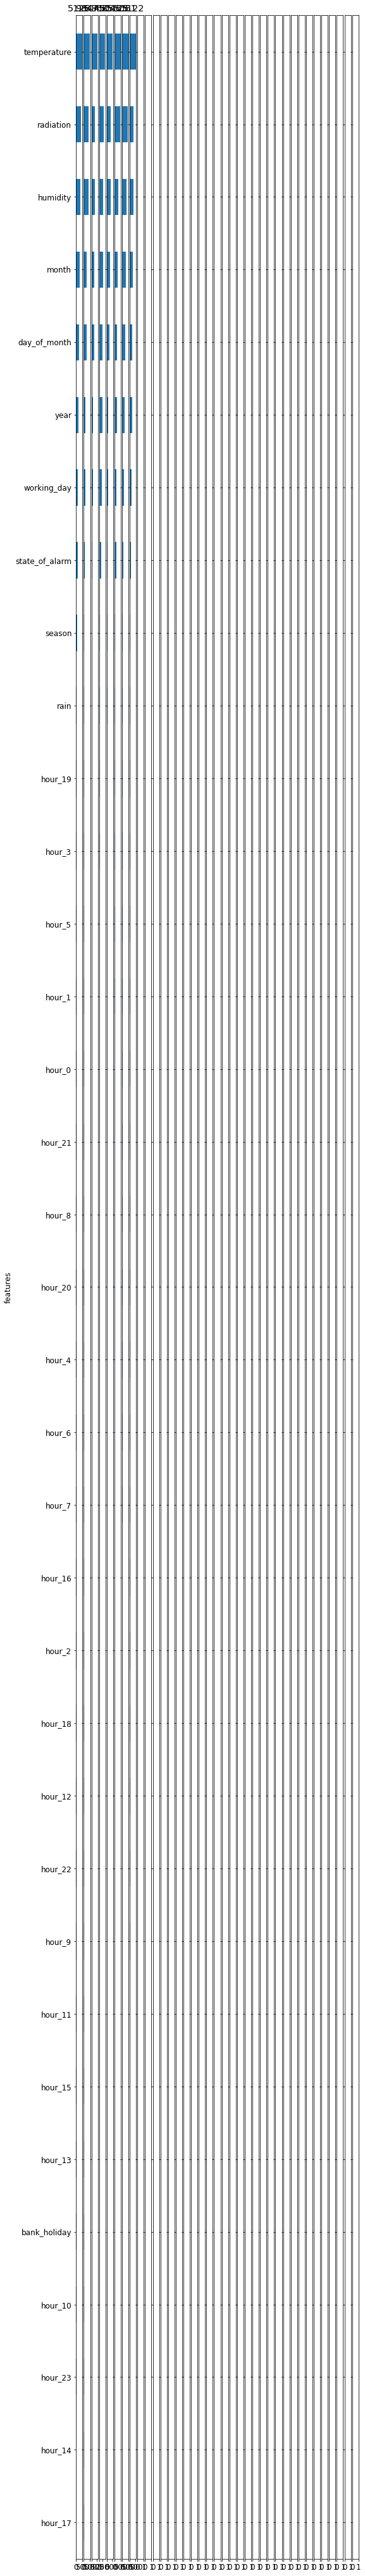

In [16]:
plot_feature_importances(ids_to_use, estimators0, column_names)

# 1. First search: `n_estimators`

In [17]:
params_1 = {
    "n_estimators": range(20, 200, 10)
}

best_params["n_estimators"] = dict()

estimators1 = {}

for node_id in ids_to_use:
    print(node_id)
    gridcv1 = GridSearchCV(xgb.XGBRegressor(learning_rate=0.1,
                                            max_depth=5,
                                            min_child_weight=1,
                                            gamma=0,
                                            subsample=0.8,
                                            colsample_bytree=0.8),
                           cv=ts_cv,
                           param_grid=params_1,
                           verbose=1,
                           scoring=scoring,
                           refit=scoring[0])

    gridcv1.fit(train_x[node_id], train_y[node_id])
    estimators1[node_id] = gridcv1.best_estimator_
    best_params["n_estimators"][node_id] = gridcv1.best_params_["n_estimators"]
    print(gridcv1.best_params_)
    print("MAE:", -pd.DataFrame(gridcv1.cv_results_).sort_values(["rank_test_neg_mean_absolute_error"]).iloc[0][
        "mean_test_neg_mean_absolute_error"])
    print("MSE:", -pd.DataFrame(gridcv1.cv_results_).sort_values(["rank_test_neg_mean_squared_error"]).iloc[0][
        "mean_test_neg_mean_squared_error"])

5126
Fitting 3 folds for each of 18 candidates, totalling 54 fits
{'n_estimators': 40}
MAE: 9.688653516165433
MSE: 168.64747622188403
9847
Fitting 3 folds for each of 18 candidates, totalling 54 fits
{'n_estimators': 20}
MAE: 4.965651581288063
MSE: 49.19962932893471
5045
Fitting 3 folds for each of 18 candidates, totalling 54 fits
{'n_estimators': 30}
MAE: 3.3755730960331953
MSE: 52.85955730425852
3685
Fitting 3 folds for each of 18 candidates, totalling 54 fits
{'n_estimators': 110}
MAE: 2.633296343768508
MSE: 13.107104278302836
5046
Fitting 3 folds for each of 18 candidates, totalling 54 fits
{'n_estimators': 20}
MAE: 4.781178590241402
MSE: 62.556790106354505
5125
Fitting 3 folds for each of 18 candidates, totalling 54 fits
{'n_estimators': 30}
MAE: 8.24201239778863
MSE: 124.1537010514548
5061
Fitting 3 folds for each of 18 candidates, totalling 54 fits
{'n_estimators': 20}
MAE: 2.3395060987361282
MSE: 11.594992335055196
5122
Fitting 3 folds for each of 18 candidates, totalling 54 fi

In [ ]:
plot_feature_importances(ids_to_use, estimators1, column_names)

# 2. Second search: first round of `max_depth`, `min_child_weight`

In [18]:
estimators2 = {}

params_2 = {'max_depth': range(3, 16, 2),
            'min_child_weight': range(1, 6, 2)}

best_params["max_depth1"] = dict()
best_params["min_child_weight1"] = dict()

for node_id in ids_to_use:
    print(node_id)

    gridcv2 = GridSearchCV(xgb.XGBRegressor(n_estimators=best_params["n_estimators"][node_id],
                                            learning_rate=0.1,
                                            gamma=0,
                                            subsample=0.8,
                                            colsample_bytree=0.8),
                           cv=ts_cv,
                           param_grid=params_2,
                           verbose=1,
                           scoring=scoring,
                           refit=scoring[0])

    gridcv2.fit(train_x[node_id], train_y[node_id])
    estimators2[node_id] = gridcv2.best_estimator_
    best_params["max_depth1"][node_id] = gridcv2.best_params_["max_depth"]
    best_params["min_child_weight1"][node_id] = gridcv2.best_params_["min_child_weight"]
    print(gridcv2.best_params_)
    print("MAE:", -pd.DataFrame(gridcv2.cv_results_).sort_values(["rank_test_neg_mean_absolute_error"]).iloc[0][
        "mean_test_neg_mean_absolute_error"])
    print("MSE:", -pd.DataFrame(gridcv2.cv_results_).sort_values(["rank_test_neg_mean_squared_error"]).iloc[0][
        "mean_test_neg_mean_squared_error"])

5126
Fitting 3 folds for each of 21 candidates, totalling 63 fits
{'max_depth': 7, 'min_child_weight': 1}
MAE: 9.627602366534163
MSE: 168.83396573297134
9847
Fitting 3 folds for each of 21 candidates, totalling 63 fits
{'max_depth': 3, 'min_child_weight': 5}
MAE: 4.8309989040182515
MSE: 46.154516120049976
5045
Fitting 3 folds for each of 21 candidates, totalling 63 fits
{'max_depth': 11, 'min_child_weight': 5}
MAE: 3.2446954581337377
MSE: 52.358646147500345
3685
Fitting 3 folds for each of 21 candidates, totalling 63 fits
{'max_depth': 7, 'min_child_weight': 5}
MAE: 2.6110794139026385
MSE: 13.698076134879862
5046
Fitting 3 folds for each of 21 candidates, totalling 63 fits
{'max_depth': 7, 'min_child_weight': 5}
MAE: 4.748759427377837
MSE: 62.620066498123265
5125
Fitting 3 folds for each of 21 candidates, totalling 63 fits
{'max_depth': 7, 'min_child_weight': 3}
MAE: 8.118111828088274
MSE: 123.30621324780198
5061
Fitting 3 folds for each of 21 candidates, totalling 63 fits
{'max_depth'

In [ ]:
plot_feature_importances(ids_to_use, estimators2, column_names)

# 3. Third search: second round of `max_depth` and `min_chid_weight`

In [19]:
estimators3 = {}
best_params["max_depth"] = dict()
best_params["min_child_weight"] = dict()

for node_id in ids_to_use:
    print(node_id)
    params_3 = {
        "max_depth": range(max(0, best_params["max_depth1"][node_id]-1), best_params["max_depth1"][node_id]+1, 1),
        "min_child_weight": range(max(0, best_params["min_child_weight1"][node_id]-1), best_params["min_child_weight1"][node_id]+1, 1)
    }
    gridcv3 = GridSearchCV(xgb.XGBRegressor(n_estimators=best_params["n_estimators"][node_id],
                                            learning_rate=0.1,
                                            gamma=0,
                                            subsample=0.8,
                                            colsample_bytree=0.8),
                           cv=ts_cv,
                           param_grid=params_3,
                           verbose=1,
                           scoring=scoring,
                           refit=scoring[0])

    gridcv3.fit(train_x[node_id], train_y[node_id])
    estimators3[node_id] = gridcv3.best_estimator_
    best_params["max_depth"][node_id] = gridcv3.best_params_["max_depth"]
    best_params["min_child_weight"][node_id] = gridcv3.best_params_["min_child_weight"]
    print(gridcv3.best_params_)
    print("MAE:", -pd.DataFrame(gridcv3.cv_results_).sort_values(["rank_test_neg_mean_absolute_error"]).iloc[0][
        "mean_test_neg_mean_absolute_error"])
    print("MSE:", -pd.DataFrame(gridcv3.cv_results_).sort_values(["rank_test_neg_mean_squared_error"]).iloc[0][
        "mean_test_neg_mean_squared_error"])

5126
Fitting 3 folds for each of 4 candidates, totalling 12 fits
{'max_depth': 7, 'min_child_weight': 0}
MAE: 9.627602366534163
MSE: 170.3199463796362
9847
Fitting 3 folds for each of 4 candidates, totalling 12 fits
{'max_depth': 3, 'min_child_weight': 5}
MAE: 4.8309989040182515
MSE: 46.154516120049976
5045
Fitting 3 folds for each of 4 candidates, totalling 12 fits
{'max_depth': 11, 'min_child_weight': 5}
MAE: 3.2446954581337377
MSE: 52.397615192149026
3685
Fitting 3 folds for each of 4 candidates, totalling 12 fits
{'max_depth': 7, 'min_child_weight': 4}
MAE: 2.5997935726138954
MSE: 13.58402066393719
5046
Fitting 3 folds for each of 4 candidates, totalling 12 fits
{'max_depth': 6, 'min_child_weight': 4}
MAE: 4.745700195011211
MSE: 62.88089311138521
5125
Fitting 3 folds for each of 4 candidates, totalling 12 fits
{'max_depth': 7, 'min_child_weight': 3}
MAE: 8.118111828088274
MSE: 123.30621324780198
5061
Fitting 3 folds for each of 4 candidates, totalling 12 fits
{'max_depth': 11, 'min

In [ ]:
plot_feature_importances(ids_to_use, estimators3, column_names)

# 4. Fourth search: gamma

In [20]:
params_4 = {
    "gamma": [i/10.0 for i in range(0,5)]
}

estimators4 = {}
best_params["gamma"] = dict()

for node_id in ids_to_use:
    print(node_id)
    gridcv4 = GridSearchCV(xgb.XGBRegressor(n_estimators=best_params["n_estimators"][node_id],
                                            max_depth=best_params["max_depth"][node_id],
                                            min_child_weight=best_params["min_child_weight"][node_id],
                                            learning_rate=0.1,
                                            subsample=0.8,
                                            colsample_bytree=0.8),
                           cv=ts_cv,
                           param_grid=params_4,
                           verbose=1,
                           scoring=scoring,
                           refit=scoring[0])

    gridcv4.fit(train_x[node_id], train_y[node_id])
    estimators4[node_id] = gridcv4.best_estimator_
    best_params["gamma"][node_id] = gridcv4.best_params_["gamma"]
    print(gridcv4.best_params_)
    print("MAE:", -pd.DataFrame(gridcv4.cv_results_).sort_values(["rank_test_neg_mean_absolute_error"]).iloc[0][
        "mean_test_neg_mean_absolute_error"])
    print("MSE:", -pd.DataFrame(gridcv4.cv_results_).sort_values(["rank_test_neg_mean_squared_error"]).iloc[0][
        "mean_test_neg_mean_squared_error"])

5126
Fitting 3 folds for each of 5 candidates, totalling 15 fits
{'gamma': 0.4}
MAE: 9.62321078858391
MSE: 171.77271638100967
9847
Fitting 3 folds for each of 5 candidates, totalling 15 fits
{'gamma': 0.0}
MAE: 4.8309989040182515
MSE: 46.154516120049976
5045
Fitting 3 folds for each of 5 candidates, totalling 15 fits
{'gamma': 0.3}
MAE: 3.2434980596913974
MSE: 52.355623065017994
3685
Fitting 3 folds for each of 5 candidates, totalling 15 fits
{'gamma': 0.3}
MAE: 2.595816498792674
MSE: 13.525168337127674
5046
Fitting 3 folds for each of 5 candidates, totalling 15 fits
{'gamma': 0.2}
MAE: 4.745699807068664
MSE: 62.880882898039154
5125
Fitting 3 folds for each of 5 candidates, totalling 15 fits
{'gamma': 0.2}
MAE: 8.11810432293168
MSE: 123.30593840355691
5061
Fitting 3 folds for each of 5 candidates, totalling 15 fits
{'gamma': 0.0}
MAE: 2.2921403637599282
MSE: 11.814937900088013
5122
Fitting 3 folds for each of 5 candidates, totalling 15 fits
{'gamma': 0.2}
MAE: 2.554108745907345
MSE: 43

In [ ]:
plot_feature_importances(ids_to_use, estimators4, column_names)

# 5. Fifth search: readjust `n_estimators`

In [21]:
params_5 = {
    "n_estimators": range(20, 200, 10)
}

estimators5 = {}
best_params["n_estimators"] = dict()

for node_id in ids_to_use:
    print(node_id)
    gridcv5 = GridSearchCV(xgb.XGBRegressor(max_depth=best_params["max_depth"][node_id],
                                            min_child_weight=best_params["min_child_weight"][node_id],
                                            gamma=best_params["gamma"][node_id],
                                            learning_rate=0.1,
                                            subsample=0.8,
                                            colsample_bytree=0.8),
                           cv=ts_cv,
                           param_grid=params_5,
                           verbose=1,
                           scoring=scoring,
                           refit=scoring[0])

    gridcv5.fit(train_x[node_id], train_y[node_id])
    estimators5[node_id] = gridcv5.best_estimator_
    best_params["n_estimators"][node_id] = gridcv5.best_params_["n_estimators"]
    print(gridcv5.best_params_)
    print("MAE:", -pd.DataFrame(gridcv5.cv_results_).sort_values(["rank_test_neg_mean_absolute_error"]).iloc[0][
        "mean_test_neg_mean_absolute_error"])
    print("MSE:", -pd.DataFrame(gridcv5.cv_results_).sort_values(["rank_test_neg_mean_squared_error"]).iloc[0][
        "mean_test_neg_mean_squared_error"])

5126
Fitting 3 folds for each of 18 candidates, totalling 54 fits
{'n_estimators': 30}
MAE: 9.622052292680843
MSE: 169.8876376759255
9847
Fitting 3 folds for each of 18 candidates, totalling 54 fits
{'n_estimators': 20}
MAE: 4.8309989040182515
MSE: 45.69652554052769
5045
Fitting 3 folds for each of 18 candidates, totalling 54 fits
{'n_estimators': 30}
MAE: 3.2434980596913974
MSE: 52.409660473840624
3685
Fitting 3 folds for each of 18 candidates, totalling 54 fits
{'n_estimators': 30}
MAE: 2.559661879493664
MSE: 12.817388470081456
5046
Fitting 3 folds for each of 18 candidates, totalling 54 fits
{'n_estimators': 20}
MAE: 4.745699807068664
MSE: 62.88088341028617
5125
Fitting 3 folds for each of 18 candidates, totalling 54 fits
{'n_estimators': 30}
MAE: 8.11810432293168
MSE: 123.30593840355691
5061
Fitting 3 folds for each of 18 candidates, totalling 54 fits
{'n_estimators': 20}
MAE: 2.2921403637599282
MSE: 11.814937900088013
5122
Fitting 3 folds for each of 18 candidates, totalling 54 fi

In [ ]:
plot_feature_importances(ids_to_use, estimators5, column_names)

# 6. Sixth search: `subsample` and `colsample_bytree`

In [22]:
params_6 = {
    'subsample':[i/10.0 for i in range(6,10)],
    'colsample_bytree':[i/10.0 for i in range(6,10)]
}

estimators6 = {}
best_params["subsample1"] = dict()
best_params["colsample_bytree1"] = dict()

for node_id in ids_to_use:
    print(node_id)
    gridcv6 = GridSearchCV(xgb.XGBRegressor(n_estimators=best_params["n_estimators"][node_id],
                                            max_depth=best_params["max_depth"][node_id],
                                            min_child_weight=best_params["min_child_weight"][node_id],
                                            gamma=best_params["gamma"][node_id],
                                            learning_rate=0.1),
                           cv=ts_cv,
                           param_grid=params_6,
                           verbose=1,
                           scoring=scoring,
                           refit=scoring[0])

    gridcv6.fit(train_x[node_id], train_y[node_id])
    estimators6[node_id] = gridcv6.best_estimator_
    best_params["subsample1"][node_id] = gridcv6.best_params_["subsample"]
    best_params["colsample_bytree1"][node_id] = gridcv6.best_params_["colsample_bytree"]
    print(gridcv6.best_params_)
    print("MAE:", -pd.DataFrame(gridcv6.cv_results_).sort_values(["rank_test_neg_mean_absolute_error"]).iloc[0][
        "mean_test_neg_mean_absolute_error"])
    print("MSE:", -pd.DataFrame(gridcv6.cv_results_).sort_values(["rank_test_neg_mean_squared_error"]).iloc[0][
        "mean_test_neg_mean_squared_error"])

5126
Fitting 3 folds for each of 16 candidates, totalling 48 fits
{'colsample_bytree': 0.9, 'subsample': 0.7}
MAE: 9.57583764788098
MSE: 168.6981650419219
9847
Fitting 3 folds for each of 16 candidates, totalling 48 fits
{'colsample_bytree': 0.6, 'subsample': 0.9}
MAE: 4.817688364207562
MSE: 45.81443646718491
5045
Fitting 3 folds for each of 16 candidates, totalling 48 fits
{'colsample_bytree': 0.8, 'subsample': 0.7}
MAE: 3.232798025683009
MSE: 52.34053148489511
3685
Fitting 3 folds for each of 16 candidates, totalling 48 fits
{'colsample_bytree': 0.8, 'subsample': 0.8}
MAE: 2.559661879493664
MSE: 12.817388470081456
5046
Fitting 3 folds for each of 16 candidates, totalling 48 fits
{'colsample_bytree': 0.8, 'subsample': 0.8}
MAE: 4.745699807068664
MSE: 62.38913832645439
5125
Fitting 3 folds for each of 16 candidates, totalling 48 fits
{'colsample_bytree': 0.8, 'subsample': 0.8}
MAE: 8.11810432293168
MSE: 123.30593840355691
5061
Fitting 3 folds for each of 16 candidates, totalling 48 fit

In [ ]:
plot_feature_importances(ids_to_use, estimators6, column_names)

# 7. Seventh search: second round of `subsample` and `colsample_bytree`

In [23]:
estimators7 = {}
best_params["subsample"] = dict()
best_params["colsample_bytree"] = dict()

for node_id in ids_to_use:
    params_7 = {
    'subsample':[i/100.0 for i in range(int(best_params["subsample1"][node_id]*100-5), int(best_params["subsample1"][node_id]*100+5), 5)],
    'colsample_bytree':[i/100.0 for i in range(int(best_params["colsample_bytree1"][node_id]*100-5), int(best_params["colsample_bytree1"][node_id]*100+5), 5)]
}
    print(node_id)
    gridcv7 = GridSearchCV(xgb.XGBRegressor(n_estimators=best_params["n_estimators"][node_id],
                                            max_depth=best_params["max_depth"][node_id],
                                            min_child_weight=best_params["min_child_weight"][node_id],
                                            gamma=best_params["gamma"][node_id],
                                            learning_rate=0.1),
                           cv=ts_cv,
                           param_grid=params_7,
                           verbose=1,
                           scoring=scoring,
                           refit=scoring[0])

    gridcv7.fit(train_x[node_id], train_y[node_id])
    estimators7[node_id] = gridcv7.best_estimator_
    best_params["subsample"][node_id] = gridcv7.best_params_["subsample"]
    best_params["colsample_bytree"][node_id] = gridcv7.best_params_["colsample_bytree"]
    print(gridcv7.best_params_)
    print("MAE:", -pd.DataFrame(gridcv7.cv_results_).sort_values(["rank_test_neg_mean_absolute_error"]).iloc[0][
        "mean_test_neg_mean_absolute_error"])
    print("MSE:", -pd.DataFrame(gridcv7.cv_results_).sort_values(["rank_test_neg_mean_squared_error"]).iloc[0][
        "mean_test_neg_mean_squared_error"])

5126
Fitting 3 folds for each of 4 candidates, totalling 12 fits
{'colsample_bytree': 0.85, 'subsample': 0.65}
MAE: 9.558177867366936
MSE: 168.2339294273734
9847
Fitting 3 folds for each of 4 candidates, totalling 12 fits
{'colsample_bytree': 0.6, 'subsample': 0.9}
MAE: 4.817688364207562
MSE: 45.81443646718491
5045
Fitting 3 folds for each of 4 candidates, totalling 12 fits
{'colsample_bytree': 0.8, 'subsample': 0.7}
MAE: 3.232798025683009
MSE: 52.34053148489511
3685
Fitting 3 folds for each of 4 candidates, totalling 12 fits
{'colsample_bytree': 0.8, 'subsample': 0.8}
MAE: 2.559661879493664
MSE: 12.817388470081456
5046
Fitting 3 folds for each of 4 candidates, totalling 12 fits
{'colsample_bytree': 0.8, 'subsample': 0.8}
MAE: 4.745699807068664
MSE: 62.471215850366896
5125
Fitting 3 folds for each of 4 candidates, totalling 12 fits
{'colsample_bytree': 0.8, 'subsample': 0.8}
MAE: 8.11810432293168
MSE: 123.30593840355691
5061
Fitting 3 folds for each of 4 candidates, totalling 12 fits
{

In [ ]:
plot_feature_importances(ids_to_use, estimators7, column_names)

# 8. Eighth search: Regularization parameters

In [24]:
estimators8 = {}
params_8 = {
    'reg_alpha': [0, 1e-5, 1e-2, 0.1, 1, 100],
    "reg_lambda": [1e-5, 1e-2, 0.1, 1, 100]
}
best_params["reg_alpha"] = dict()
best_params["reg_lambda"] = dict()

for node_id in ids_to_use:
    print(node_id)
    gridcv8 = GridSearchCV(xgb.XGBRegressor(n_estimators=best_params["n_estimators"][node_id],
                                            max_depth=best_params["max_depth"][node_id],
                                            min_child_weight=best_params["min_child_weight"][node_id],
                                            gamma=best_params["gamma"][node_id],
                                            subsample=best_params["subsample"][node_id],
                                            colsample_bytree=best_params["colsample_bytree"][node_id],
                                            learning_rate=0.1),
                           cv=ts_cv,
                           param_grid=params_8,
                           verbose=1,
                           scoring=scoring,
                           refit=scoring[0])

    gridcv8.fit(train_x[node_id], train_y[node_id])
    estimators8[node_id] = gridcv8.best_estimator_
    best_params["reg_alpha"][node_id] = gridcv8.best_params_["reg_alpha"]
    best_params["reg_lambda"][node_id] = gridcv8.best_params_["reg_lambda"]
    print(gridcv8.best_params_)
    print("MAE:", -pd.DataFrame(gridcv8.cv_results_).sort_values(["rank_test_neg_mean_absolute_error"]).iloc[0][
        "mean_test_neg_mean_absolute_error"])
    print("MSE:", -pd.DataFrame(gridcv8.cv_results_).sort_values(["rank_test_neg_mean_squared_error"]).iloc[0][
        "mean_test_neg_mean_squared_error"])

5126
Fitting 3 folds for each of 30 candidates, totalling 90 fits
{'reg_alpha': 0.1, 'reg_lambda': 1e-05}
MAE: 9.539795674337968
MSE: 167.3232091917276
9847
Fitting 3 folds for each of 30 candidates, totalling 90 fits
{'reg_alpha': 0, 'reg_lambda': 100}
MAE: 4.813113283751249
MSE: 45.7876998084656
5045
Fitting 3 folds for each of 30 candidates, totalling 90 fits
{'reg_alpha': 1, 'reg_lambda': 1}
MAE: 3.2220514184329403
MSE: 52.309491484233796
3685
Fitting 3 folds for each of 30 candidates, totalling 90 fits
{'reg_alpha': 1, 'reg_lambda': 0.1}
MAE: 2.556792723251488
MSE: 12.781127344273393
5046
Fitting 3 folds for each of 30 candidates, totalling 90 fits
{'reg_alpha': 100, 'reg_lambda': 100}
MAE: 4.735480152716086
MSE: 62.56176936083761
5125
Fitting 3 folds for each of 30 candidates, totalling 90 fits
{'reg_alpha': 0, 'reg_lambda': 1}
MAE: 8.11810432293168
MSE: 123.26396970963668
5061
Fitting 3 folds for each of 30 candidates, totalling 90 fits
{'reg_alpha': 100, 'reg_lambda': 0.1}
MAE:

In [ ]:
plot_feature_importances(ids_to_use, estimators8, column_names)

In [ ]:
best_params

# 9. Reduce learning rate

In [25]:
estimators9 = {}
params_9 = {
    "learning_rate": [0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.5]
}
best_params["learning_rate"] = dict()

for node_id in ids_to_use:
    print(node_id)
    gridcv9 = GridSearchCV(xgb.XGBRegressor(n_estimators=best_params["n_estimators"][node_id],
                                            max_depth=best_params["max_depth"][node_id],
                                            min_child_weight=best_params["min_child_weight"][node_id],
                                            gamma=best_params["gamma"][node_id],
                                            subsample=best_params["subsample"][node_id],
                                            colsample_bytree=best_params["colsample_bytree"][node_id],
                                            reg_alpha=best_params["reg_alpha"][node_id],
                                            reg_lambda=best_params["reg_lambda"][node_id]),
                           cv=ts_cv,
                           param_grid=params_9,
                           verbose=1,
                           scoring=scoring,
                           refit=scoring[0])

    gridcv9.fit(train_x[node_id], train_y[node_id])
    estimators9[node_id] = gridcv9.best_estimator_
    best_params["learning_rate"][node_id] = gridcv9.best_params_["learning_rate"]
    print(gridcv9.best_params_)
    print("MAE:", -pd.DataFrame(gridcv9.cv_results_).sort_values(["rank_test_neg_mean_absolute_error"]).iloc[0][
        "mean_test_neg_mean_absolute_error"])
    print("MSE:", -pd.DataFrame(gridcv9.cv_results_).sort_values(["rank_test_neg_mean_squared_error"]).iloc[0][
        "mean_test_neg_mean_squared_error"])

5126
Fitting 3 folds for each of 7 candidates, totalling 21 fits
{'learning_rate': 0.1}
MAE: 9.539795674337968
MSE: 167.3232091917276
9847
Fitting 3 folds for each of 7 candidates, totalling 21 fits
{'learning_rate': 0.1}
MAE: 4.813113283751249
MSE: 45.91944092979464
5045
Fitting 3 folds for each of 7 candidates, totalling 21 fits
{'learning_rate': 0.1}
MAE: 3.2220514184329403
MSE: 52.3202803541576
3685
Fitting 3 folds for each of 7 candidates, totalling 21 fits
{'learning_rate': 0.1}
MAE: 2.556792723251488
MSE: 12.784768337615576
5046
Fitting 3 folds for each of 7 candidates, totalling 21 fits
{'learning_rate': 0.05}
MAE: 4.508419126514103
MSE: 65.212869059236
5125
Fitting 3 folds for each of 7 candidates, totalling 21 fits
{'learning_rate': 0.1}
MAE: 8.11810432293168
MSE: 123.30593840355691
5061
Fitting 3 folds for each of 7 candidates, totalling 21 fits
{'learning_rate': 0.1}
MAE: 2.269766361383447
MSE: 11.693848002559216
5122
Fitting 3 folds for each of 7 candidates, totalling 21 f

# 10. Train best estimator

In [1]:
import pandas as pd
from graph_traffic.merge_data import merge_data
from graph_traffic.custom_transformer import get_column_names, transform_df
from graph_traffic.config import project_path
from graph_traffic.model_selection import get_node_ids
from sklearn.metrics import mean_absolute_error, mean_squared_error
import xgboost as xgb
import pickle

ids_to_use

import pickle
from graph_traffic.config import project_path

with open(f"{project_path}/training_history/xgboost/bestparams.pkl", "rb") as f:
    best_params = pickle.load(f)

In [2]:
dfs_dict = {}
maes_per_sensor = {}
mses_per_sensor = {}

for node_id in ids_to_use:
    df = merge_data(node_id, data_dict["from_date"], data_dict["to_date"], data_dict["target"], mmagns)
    dfs_dict[node_id] = transform_df(df, meteo_dict, temporal_dict, data_dict["interactions"], data_dict["target"])

for node_id in ids_to_use:
    print()
    print(node_id)
    maes_per_sensor[node_id] = dict()
    mses_per_sensor[node_id] = dict()
    for train_until in pd.date_range("2021-05-27", "2021-11-30", freq="1M"):
        print(train_until, end="\r")
        # all observations before or on 27th April 2021 are in the training
        train_data_size = dfs_dict[node_id][(dfs_dict[node_id][:, 28]<=2020) |
                                            ((dfs_dict[node_id][:, 30]<=train_until.month) & (dfs_dict[node_id][:, 31]<=train_until.day))].shape[0]
        test_data_size = dfs_dict[node_id][(dfs_dict[node_id][:, 28]>=2020) &
                                           ((dfs_dict[node_id][:, 30]>=train_until.month) & (dfs_dict[node_id][:, 31]>=train_until.day)) &
                                           ((dfs_dict[node_id][:, 30]<=train_until.month+1) & (dfs_dict[node_id][:, 31]<=31))
        ].shape[0]
        train_x[node_id] = dfs_dict[node_id][:train_data_size, 1:]
        train_y[node_id] = dfs_dict[node_id][:train_data_size, 0].ravel()

        test_x[node_id] = dfs_dict[node_id][train_data_size:train_data_size+test_data_size, 1:]
        test_y[node_id] = dfs_dict[node_id][train_data_size:train_data_size+test_data_size, 0].ravel()

        reg = xgb.XGBRegressor(
            n_estimators=best_params["n_estimators"][node_id],
            max_depth=best_params["max_depth"][node_id],
            min_child_weight=best_params["min_child_weight"][node_id],
            gamma=best_params["gamma"][node_id],
            subsample=best_params["subsample"][node_id],
            colsample_bytree=best_params["colsample_bytree"][node_id],
            reg_alpha=best_params["reg_alpha"][node_id],
            reg_lambda=best_params["reg_lambda"][node_id],
            learning_rate=best_params["learning_rate"][node_id]
        )

        reg.fit(train_x[node_id], train_y[node_id])
        pred = reg.predict(test_x[node_id])
        maes_per_sensor[node_id][train_until] = mean_absolute_error(test_y[node_id], pred)
        mses_per_sensor[node_id][train_until] = mean_squared_error(test_y[node_id], pred)

NameError: name 'ids_to_use' is not defined

In [41]:
import pickle
from graph_traffic.config import project_path

with open(f"{project_path}/training_history/xgboost/bestparams.pkl", "rb") as f:
    best_params = pickle.load(f)

In [43]:
with open(f"{project_path}/training_history/xgboost/maes.pkl", "wb") as f:
    pickle.dump(maes_per_sensor, f)

with open(f"{project_path}/training_history/xgboost/mses.pkl", "wb") as f:
    pickle.dump(mses_per_sensor, f)

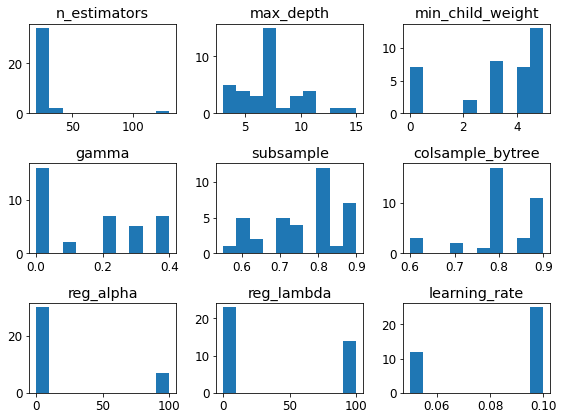

In [63]:
import matplotlib.pyplot as plt
best_params = {k: v for (k,v) in best_params.items() if not k.endswith("1")}
fig, axs = plt.subplots(3, 3, figsize=(8, 3*2))
for i, (param, values) in enumerate(best_params.items()):
    row = i // 3
    column = i % 3
    ax = axs[row, column]
    ax.hist(values.values())
    ax.set_title(param)
#axs[-1, 1].axis("off")
#axs[-1, 2].axis("off")
fig.tight_layout()
fig.savefig(f"{project_path}/training_history/xgboost/parameters.png")

In [71]:
maes = pd.DataFrame(maes_per_sensor)
maes.index = ["Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
maes = maes.T
maes["avg MAE"] = maes.mean(axis=1)
maes["std MAE"] = maes.std(axis=1)
maes = maes[["avg MAE", "std MAE"]].round(4)
maes.to_csv(f"{project_path}/training_history/xgboost/maes.csv")
maes

,avg MAE,std MAE
5126,8.3273,0.2049
9847,4.5199,0.1480
5045,3.1832,0.4750
3685,1.9066,0.0547
5046,2.3691,0.2585
5125,7.6285,0.2067
5061,1.9819,0.1045
5122,2.1326,0.5589
5245,4.1969,0.3616
5047,1.5856,0.0472


In [72]:
mses = pd.DataFrame(mses_per_sensor)
mses.index = ["Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
mses = mses.T
mses["avg MAE"] = mses.mean(axis=1)
mses["std MAE"] = mses.std(axis=1)
mses = mses[["avg MAE", "std MAE"]].round(4)
mses.to_csv(f"{project_path}/training_history/xgboost/mses.csv")
mses

,avg MAE,std MAE
5126,128.1995,7.6076
9847,37.6795,2.6659
5045,24.8320,6.8884
3685,7.1189,0.5049
5046,16.9383,3.5774
5125,116.0549,8.8168
5061,8.9810,0.9322
5122,13.8395,9.6872
5245,102.0864,19.2979
5047,7.4151,0.7440


In [76]:
df = pd.merge(maes, mses, left_index=True, right_index=True)
df.columns = ["Media MAE", "Desviación estándar MAE", "Media MSE", "Desviación estándar MSE"]
df.to_csv(f"{project_path}/training_history/xgboost/losses.csv")
df

,Media MAE,Desviación estándar MAE,Media MSE,Desviación estándar MSE
5126,8.3273,0.2049,128.1995,7.6076
9847,4.5199,0.1480,37.6795,2.6659
5045,3.1832,0.4750,24.8320,6.8884
3685,1.9066,0.0547,7.1189,0.5049
5046,2.3691,0.2585,16.9383,3.5774
5125,7.6285,0.2067,116.0549,8.8168
5061,1.9819,0.1045,8.9810,0.9322
5122,2.1326,0.5589,13.8395,9.6872
5245,4.1969,0.3616,102.0864,19.2979
5047,1.5856,0.0472,7.4151,0.7440
